# Lecture 11: Agent-Based Model of Covid-19

by Peter Steiglechner, peter.steiglechner@gmail.com, 

- developed from March 2020 to Oct 2020
- last updated Nov 2023



### Overview 
- Each agent is a person
- Agents are categorised into three age groups 
- Infection dynamics:
    - A susceptible agent may catch the virus when in contact with an infectious agent. The probability to catch the virus is given by the infectiousness of the infectious agent.
    - Upon becoming infected, the infection course (timing, type, and outcome) is determined stochastically based on distributions. These distributions are based on educated guesses or inferred from data. Some characteristics also depend on the age of the infected agent.
- Agents are embedded in a fixed interaction network (here a Watts-Strogatz-Network). Links between agents (nodes) represent physical contact that may result in an spreading event from one agent to the other. All agents interact asynchronously with one of their neighbours in one time step. 
- Policies can be implemented and analysed to investigate their effectiveness: e.g.
    - reducing the number of contacts in the network
    - reduce contacts for symptomatic agents
    - reduce infectiousness by wearing a mask

The timestep of the simulation is 1 day.

The number of agents is set to 1000 including children, adults (with low risk) and elderly (with higher risk).

### Documentation 
For details, refer to the Lecture slides 11 of "Modelling and Analysis of Complex Systems" (Agostino Merico) Constructor University 2023

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import networkx as nx
from plot_functions import *

plt.rcParams.update({"font.size": 10})  # increase the fontsize in all plots




# Global fixed parameters

In [2]:
age_groups = [ "child" , "adult" , "elderly"]
# Fractions of age groups in the population: 20% children, 50% adults, 30% elderly
fraction_age_groups = [0.2, 0.5, 0.3]  # should sum to 1

"""
Corona specific distributions and probabilities
"""
# base_infectiousness
# = Distribution from which we draw the infectiousness of an individual
#       Educated Guess (there are a few super spreaders, many not-so infectious people)
#       --> long tail towards high values of infectiousness
# For advanced assignment:
#       This needs to be adjusted such that we get a mean reproductive number R (in the beginning of the
#       simulation where (nearly) all agents are susceptible) close to realistic values.
base_infectiousness_dist = stats.beta(1, 3)

# p_symptomatic
# = Probability of a member of a specific age group to have a symptomatic infection.
# Why this distribution?
#       Educated Guess (related to the --> manifestation index)
p_symptomatic = {"child": 0.1, "adult": 0.5, "elderly": 0.8}

# incubation_period_dist
# = Distribution of incubation periods
# estimated by
#   Lauer, et. al (2020) "The Incubation Period of Coronavirus Disease 2019 (COVID-19). From Publicly Reported
#       Confirmed Cases: Estimation and Application" (Table in Appendix 2)
#   Mean roughly 5.8 days. Long tail.
incubation_period_dist = stats.gamma(5.807, 0.948)

# case_fatality_ratio = Probability that given a person has symptoms, the Covid infection leads to her death
#                       for each risk group
# Educated Guess (children "don't" die, adults seldom, risk group roughly 5%)
case_fatality_rate = {"child": 0.0001, "adult": 0.005, "elderly": 0.05}

# infectiousness_pre/post/asymptimatic
# = relative infectiousness depending on the type of infection w.r.t. symptomatic infectiousness
# Why these values?
#   educated guess
#       pre-symptom cases: the transmission of the virus is smaller than with symptoms,
#       asymptomatic cases: have significantly smaller viral loads
relative_infectiousness = {"infectious_preSymptom": 0.5, "infectious_symptomatic": 1, "infectious_asymptomatic": 0.2}

# Time of infectiousness before/after symptom onset.
# = time of potential infectiousness of an agent before/after symptom onset
# (corresponds to the same period for asymptotic cases)
# Why these values?
#   Some Sources
#       He, Xi, Eric H. Y. Lau, Peng Wu, Xilong Deng, Jian Wang, Xinxin Hao, Yiu Chung Lau, et al. “Temporal Dynamics
#       in Viral Shedding and Transmissibility of COVID-19.” Nature Medicine 26,
#
#       Ferguson, N., D. Laydon, G. Nedjati Gilani, N. Imai, K. Ainslie, M. Baguelin, S. Bhatia, et al. “Report 9:
#       Impact of Non-Pharmaceutical Interventions (NPIs) to Reduce COVID19 Mortality and Healthcare Demand.”
#       Report. 20, March 16, 2020.
#
#       Woelfel, Roman, Victor M. Corman, Wolfgang Guggemos, Michael Seilmaier, Sabine Zange, Marcel A. Mueller,
#       Daniela Niemeyer, et al. “Virological Assessment of Hospitalized Patients with COVID-2019.” Nature 581
#
#       ECDC (2020): https://www.ecdc.europa.eu/en/covid-19/facts/questions-answers-basic-facts
#
#   - He (2020): roughly 2 days before symptom onset;
#   - Ferguson (2020) uses 0.5 days before
#   Note: He(2020) actually corrected recently to ca. 5 days before symptom onset
#   - Woelfel (2020) says "virus shedding was very high during the first week of symptoms", peak at day 4.
#   - He (2020) (corrected): The infeciousness peaks around symptom onset.
#   - ECDC(2020) says: infectiousness starts up to 2 to 2.5 days before, with a peak at symptom onset, then fast decline
#
time_infectious_preSymptomstart = 2  # days before symptom onset
time_infectious_postSymptomstart = 4  # days after symptom onset



# Simulation specific parameter choices

In [3]:
FOLDER = "figures/"  # Folder to save the figures in

n_agents = 1000  # Number of agents in total
n_infected_init = 2  # Number of agents in state "exposed" at t=0.




# Agent class

In [4]:
class Agent:
    """ Empty class, filled during initialise() and potentially during catch_virus(agent, t) """
    pass

# Initialise

In [5]:
def initialise():
    """
    Initialise all agents.
    :return:
    """
    global agents
    agents = []

    for i in range(n_agents):
        ag = Agent()
        ag.id = i					# Unique ID
        ag.health_state = "susceptible"	# health state
        ag.age = np.random.choice(age_groups, p=fraction_age_groups)
        ag.r = np.nan  # LATER: for calculating the r-value
        ag.t_e = np.nan  # LATER: for plotting infection dynamics.
        agents.append(ag)

    # Let N_INFECTED_INIT randomly chosen agents catch the virus at t=0
    infected_agents = np.random.choice(agents, size=n_infected_init)
    for ag in infected_agents:
        catch_virus(ag, 0)		# agent ag catches virus at time 0.

    return


In [6]:
def initialise_network(_seed, plotting=True, **kwargs_network):
    """
    Create Network (nodes taken from agents, links created randomly) and
    :param plotting: (Bool, default = True)
    :param kwargs_network: dict.  for Watts-Strogatz Network: We need to give k and p. Hence, "k=10, p=2"
    :return ws_net: The network including all links between the nodes (agents).
    """
    n_ws = len(agents)  # All agents are nodes, their id is equal to their node index
    k_ws = kwargs_network["k"]  # number of links to left/right neighbours per agent
    p_ws = kwargs_network["p"]  # probability for a link to flip
    ws_network = nx.watts_strogatz_graph(n_ws, k_ws, p_ws, seed=int(_seed))
    
    if plotting:
        print("Plotting Network...", end="")
        plot_net(ws_network, agents)
        print("DONE.")
    
    return ws_network

# Update procedure and helper functions

In [7]:

def update(t_now):
    """
    Perform one update step, i.e. update all agents in random order!
    :param t_now:
    :return:
    """
    queue = np.random.choice(agents, size=n_agents, replace=False)
    for ag in queue:

        if ag.health_state == "susceptible":
            # agent is susceptible: Do nothing and "wait to be infected"
            pass

        if ag.health_state == "latent":
            # agent is exposed and caught the virus: Check if time for infectiousness start is exceeded
            if t_now >= ag.infectious_period[0]:
                if ag.symptomatic:
                    ag.health_state = "infectious_preSymptom"
                else:
                    ag.health_state = "infectious_asymptomatic" 

        if ag.health_state == "infectious_preSymptom":
            # infectious: Check if time for symptom onset is exceeded
            if t_now >= ag.t_onset_symptoms:
                ag.health_state = "infectious_symptomatic"

        if "infectious" in ag.health_state: 
            if t_now >= ag.infectious_period[1]:
                # Recover or die from infection.
                if ag.fatal_case:
                    ag.health_state = "dead" 
                else:
                    ag.health_state = "recovered"  
            
            # potentially infect others
            infect_others(ag, t_now)

In [8]:
def catch_virus(ag, t_exposure):
    """
    Determine the course of the infection upon being exposed and catching the virus.
    An agent ag has been in contact (i.e. exposed) with an infectious individual AND has caught the virus.
    - the agent's state switches to latent exposed (and t_e to the exposure time).
    - we determine the agent's infection specific properties:
        - symptomatic?
        - infectious_period
        - t_onset_symptoms (if symptomatic)
        - fatal? (if symptomatic)
        - individual_infectiousness
    - we define the agent's r value (how many agents did this person infect?) and initialise it with 0.

    :param ag: (object). Instance of class Agent. The agent that was exposed to the virus and caught it.
    :param t_exposure: (float). The time at which the agent catches the virus
    :return: --   (just changing agent ag's attributes)
    """

    ag.health_state = "latent"  # Exposed but latent
    ag.t_e = t_exposure

    # Probability that the infection will be symptomatic (dependent on risk_group)
    p_s = p_symptomatic[ag.age]
    ag.symptomatic = np.random.choice([True, False], p=[p_s, 1 - p_s])

    incubation_period = incubation_period_dist.rvs()
    ag.infectious_period = [
        ag.t_e + incubation_period - time_infectious_preSymptomstart,
        ag.t_e + incubation_period + time_infectious_postSymptomstart
    ]
    if ag.symptomatic:
        # Symptomatic Case
        ag.t_onset_symptoms = ag.t_e + incubation_period

        # Probability to die, given symptomatic case
        p_d = case_fatality_rate[ag.age]
        ag.fatal_case = np.random.choice([True, False], p=[p_d, 1 - p_d])
    else:
        ag.t_onset_symptoms = np.nan
        ag.fatal_case = False
    ag.base_infectiousness = base_infectiousness_dist.rvs()   # * factor (health_state)

    ag.r = 0
    
    return


                        
    

In [9]:
def infect_others(ag, t_now):
    """
    An agent ag can infect its linked contacts each with a probability dependent on its base infectiousness and state. 

    :param ag: (object). instance of class Agent.
    :param t_now: (float). current time
    :return: --  
    """
    global agents, network
    if "infectious" in ag.health_state:
            # Get Infectiousness:
            prob_infect = ag.base_infectiousness * relative_infectiousness[ag.health_state]

            # potentially infect others!
            # determine neighbours
            linked_contacts = list(network.adj[ag.id])  # very slow!

            for c in linked_contacts:
                contact_person = agents[c]
                # Potentially infect this contact person.
                if contact_person.health_state == "susceptible":
                    if np.random.random() < prob_infect:
                        catch_virus(contact_person, t_now)
                        ag.r += 1
    return 

## Observe

In [10]:
def observe(agents):
    states_of_agents = [ag.health_state for ag in agents]
    N_s = states_of_agents.count("susceptible")
    N_l = states_of_agents.count("latent")
    N_ia = states_of_agents.count("infectious_asymptomatic")
    N_ips = states_of_agents.count("infectious_preSymptom")
    N_is = states_of_agents.count("infectious_symptomatic")
    N_r = states_of_agents.count("recovered")
    N_d = states_of_agents.count("dead")
    return np.array([N_s, N_l, N_ia, N_ips, N_is, N_r, N_d])

## Run function: 
1) initialise agents and network
2) simulate
3) observe
4) plot observations

In [11]:
def run(_seed, t_array, k_ws, p_ws):
    """ Run the simulation with the current random seed """
    global agents, network
    np.random.seed(_seed)

    """
    INITIALISE
    """
    agents = []  # list of all agents (ordered by index)
    initialise()  # Initialise all agents
    network = initialise_network(_seed, plotting=False, k=k_ws, p=p_ws)

    """
    MAIN UPDATING
    """
    states = ["susceptible", "latent", "infectious_asymptomatic", "infectious_preSymptom", "infectious_symptomatic", "recovered", "dead"]
    statesAbbrv = ["S", "L", "I_asymp", "I_preSymp", "I_symp", "R", "D"]
    print("t, #" + ", #".join(statesAbbrv))
    results = np.empty([len(t_array), len(states)])

    for n, _t in enumerate(t_array):
        # update one time-step
        update(_t)
        # Store Results
        results[n,:] = observe(agents)
        print(_t, results[n,:])

    '''
    Plotting
    '''
    title = r"$n$" + r"={:d}, $N_l(t=0)$={:d}, Net: Watts-Strogatz ({:d}, {:.2f}) seed={:d}".format(
        n_agents, n_infected_init, k_ws, p_ws, _seed)
    filename = "AggregateResults_n-{:d}-{:d}_WS({:d},{:.0e})_seed{:d}".format(
        n_agents, n_infected_init, k_ws, p_ws, _seed)
    plot_statistics(t_array, results, states, title=title, filename=FOLDER + filename)

    return results, states

# MAIN: do simulations

Run a CoronaABM simulation with small-world network (6, 0.1) for times t=0 - 400, for random seed 64
t, #S, #L, #I_asymp, #I_preSymp, #I_symp, #R, #D
1 [998.   2.   0.   0.   0.   0.   0.]
2 [998.   1.   1.   0.   0.   0.   0.]
3 [997.   2.   1.   0.   0.   0.   0.]
4 [996.   2.   1.   1.   0.   0.   0.]
5 [993.   4.   2.   1.   0.   0.   0.]
6 [992.   5.   2.   0.   1.   0.   0.]
7 [990.   6.   2.   1.   1.   0.   0.]
8 [989.   7.   1.   1.   1.   1.   0.]
9 [987.   7.   2.   1.   2.   1.   0.]
10 [986.   8.   2.   1.   1.   2.   0.]
11 [984.   8.   3.   0.   2.   3.   0.]
12 [983.   7.   3.   2.   2.   3.   0.]
13 [982.   7.   3.   3.   1.   4.   0.]
14 [979.   9.   4.   1.   3.   4.   0.]
15 [977.  10.   4.   0.   3.   6.   0.]
16 [976.  10.   5.   0.   3.   6.   0.]
17 [973.  12.   3.   1.   3.   8.   0.]
18 [973.   9.   6.   1.   1.  10.   0.]
19 [967.  11.   7.   3.   1.  11.   0.]
20 [963.  14.   6.   4.   1.  12.   0.]
21 [958.  17.   7.   1.   4.  13.   0.]
22 [958.  14.   7. 

79 [616.  48.  31.   8.  23. 273.   1.]
80 [606.  46.  33.   9.  23. 282.   1.]
81 [594.  49.  34.  11.  24. 287.   1.]
82 [584.  46.  35.  11.  20. 303.   1.]
83 [573.  53.  33.   8.  19. 313.   1.]
84 [560.  53.  29.  11.  20. 326.   1.]
85 [551.  60.  24.  10.  19. 335.   1.]
86 [540.  57.  27.   6.  22. 347.   1.]
87 [530.  57.  26.  12.  18. 355.   2.]
88 [523.  51.  24.  15.  17. 368.   2.]
89 [507.  53.  31.  13.  22. 372.   2.]
90 [492.  59.  32.   9.  21. 385.   2.]
91 [481.  60.  36.   9.  25. 387.   2.]
92 [465.  60.  39.   9.  24. 401.   2.]
93 [453.  65.  40.   7.  22. 411.   2.]
94 [441.  68.  39.   8.  18. 423.   3.]
95 [433.  62.  36.  13.  16. 437.   3.]
96 [427.  55.  38.  14.  17. 446.   3.]
97 [411.  58.  38.  14.  20. 456.   3.]
98 [394.  65.  31.  13.  22. 472.   3.]
99 [380.  70.  31.  10.  27. 479.   3.]
100 [375.  62.  32.  13.  27. 488.   3.]
101 [369.  54.  33.  15.  24. 502.   3.]
102 [358.  53.  33.  12.  26. 514.   4.]
103 [348.  48.  38.  10.  25. 527.   

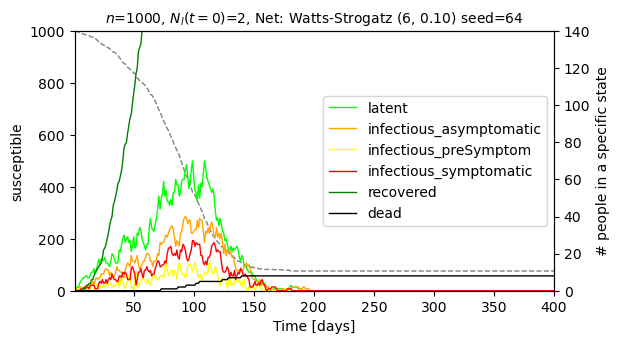

In [12]:
'''
RUN
'''
t_array=np.arange(1,401)

seed = 64  # Set random seed, so that running the model again with the same seed results in the same output.
agents = []     # Will be loaded with a list of agents
network = {}        # Will be loaded with the network, i.e. with Nodes and Links.
k_ws = 6
p_ws = 0.1
print(f"Run a CoronaABM simulation with small-world network ({k_ws}, {p_ws}) for times t=0 - {t_array[-1]}, for random seed {seed}")
results, states = run(seed, t_array=t_array, k_ws = k_ws, p_ws = p_ws)
print("...done")



plotted: 'network of agents at t=400' as figures/network_(6,0.1)_t400_seed64.png


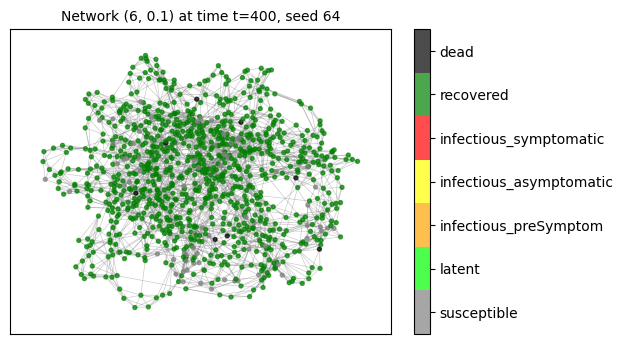

In [13]:
'''
Plot the network after the simulation 
'''
# adapt t_array=np.arange(0,t) if you want to plot the network at time t

network = initialise_network(seed, plotting=False,k=k_ws, p=p_ws)
fname = plot_states_network(agents, seed, t_array, network, k_ws, p_ws)
print(f"plotted: 'network of agents at t={t_array[-1]}' as {fname}")

plotted: 'R0 over time' as figures/R0values_N-1000-2_WS(6,1e-01)_seed64


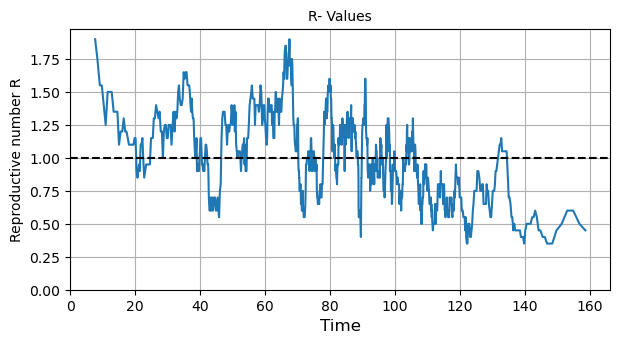

In [14]:
"""
ADVANCED:
Plot R0
"""
fname = FOLDER+f"R0values_N-{n_agents:d}-{n_infected_init:d}_WS({k_ws:d},{p_ws:.0e})_seed{seed:d}"
plot_r_values(agents, fname=fname)
print(f"plotted: 'R0 over time' as {fname}")